In [1]:
import torch
import pickle
import copy
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Rectangle
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
import sys
sys.path.append("..")
from experiment.utils_experiment import * 

In [2]:
font = {'family' : 'serif',
         'size'   : 12,
         'serif':  'cmr10'
         }

matplotlib.rc('font', **font)
plt.rcParams['axes.unicode_minus'] = False


In [ ]:
# path with results
file_path = "/Users/melodiemonod/projects/2024/deep_rl_liquidation/online/"

In [3]:
# Define a color palette
color_optimal = "#DD5746" 
color_ddpg ="#4793AF"

In [6]:
# linear decrease
job_name = "experiment_2-exponential_decay_kernel_decrease"
output_path_ld = file_path + job_name + "/"

# linear increase
job_name = "experiment_2-exponential_decay_kernel_increase"
output_path_li = file_path + job_name + "/"

In [7]:
env_simulation_ld = load_object(output_path_ld, "environment")
episodes_ld = load_object(output_path_ld, "episodes")
kernel_scales_ld = load_object(output_path_ld, "kernel_scale")
kernel_decays_ld = load_object(output_path_ld, "kernel_decay")
best_actions_ld = load_object(output_path_ld, "best_actions")
best_total_reward_ld = load_object(output_path_ld, "best_total_reward")
executed_actions_ld = load_object(output_path_ld, "executed_actions")
executed_total_reward_ld = load_object(output_path_ld, "executed_total_reward")

env_simulation_li = load_object(output_path_li, "environment")
episodes_li = load_object(output_path_li, "episodes")
kernel_scales_li = load_object(output_path_li, "kernel_scale")
kernel_decays_li = load_object(output_path_li, "kernel_decay")
best_actions_li = load_object(output_path_li, "best_actions")
best_total_reward_li = load_object(output_path_li, "best_total_reward")
executed_actions_li = load_object(output_path_li, "executed_actions")
executed_total_reward_li = load_object(output_path_li, "executed_total_reward")

In [10]:
# number of episodes
n_episode = len(kernel_scales_ld)

In [11]:
env_simulation_ld.termination_time = int(env_simulation_ld.observation_space["time"].high[0] + 1)
env_simulation_li.termination_time = int(env_simulation_li.observation_space["time"].high[0] + 1)

# Optimal strategy

In [12]:
# THIS CELL CAN TAKE UP TO 20 MINUTES TO RUN

# Reset kernel
env_simulation_ld.kernel.reset_parameter()
env_simulation_ld.kernel.reset_history()

# Initialize lists to store results
optimal_actions_list_ld = []
optimal_total_reward_list_ld = []

for episode in range(n_episode):
        
    episode += 1 # start episode at 0
        
    # kernel scale according to step function
    if episode > 1:
        env_simulation_ld.kernel.update()
    
    # store optimal actions and associated rewards
    if episode in episodes_ld:
        (
            optimal_actions,
            optimal_best_rewards,
            optimal_total_reward,
        ) = get_optimal_strategy(env_simulation_ld)
        optimal_cumulative_rewards = np.cumsum(optimal_best_rewards)
        optimal_actions_list_ld.append(optimal_actions)
        optimal_total_reward_list_ld.append(optimal_total_reward)

In [13]:
# THIS CELL CAN TAKE UP TO 20 MINUTES TO RUN

# Reset kernel
env_simulation_li.kernel.reset_parameter()
env_simulation_li.kernel.reset_history()

# Initialize lists to store results
optimal_actions_list_li = []
optimal_total_reward_list_li = []

for episode in range(n_episode):
        
    episode += 1 # start episode at 0
        
    # kernel scale according to step function
    if episode > 1:
        env_simulation_li.kernel.update()
    
    # store optimal actions and associated rewards
    if episode in episodes_li:
        (
            optimal_actions,
            optimal_best_rewards,
            optimal_total_reward,
        ) = get_optimal_strategy(env_simulation_li)
        optimal_cumulative_rewards = np.cumsum(optimal_best_rewards)
        optimal_actions_list_li.append(optimal_actions)
        optimal_total_reward_list_li.append(optimal_total_reward)

# Data transformation

In [14]:
# Number of replay
n_replay = 1
episodes_selected = episodes_li[::n_replay]

# Convert best reward tensor to list
best_total_reward_list_li = [tensor.item() for tensor in best_total_reward_li]
executed_total_reward_list_li = [tensor.item() for tensor in executed_total_reward_li]

best_total_reward_list_ld = [tensor.item() for tensor in best_total_reward_ld]
executed_total_reward_list_ld = [tensor.item() for tensor in executed_total_reward_ld]

# to array best reward
best_total_reward_array_li = np.array(best_total_reward_list_li) 
executed_total_reward_array_li = np.array(executed_total_reward_list_li) 

best_total_reward_array_ld = np.array(best_total_reward_list_ld) 
executed_total_reward_array_ld = np.array(executed_total_reward_list_ld) 

# to array optimal reward
optimal_total_reward_array_li = np.array(optimal_total_reward_list_li)
optimal_total_reward_array_ld = np.array(optimal_total_reward_list_ld)

# transform best action to pd
pd_best_actions_li = pd.DataFrame([-x.numpy() for x in best_actions_li])
pd_best_actions_ld = pd.DataFrame([-x.numpy() for x in best_actions_ld])

# transform optimal action to pd
pd_optimal_actions_li = pd.DataFrame([-np.array(x) for x in optimal_actions_list_li])
pd_optimal_actions_ld = pd.DataFrame([-np.array(x) for x in optimal_actions_list_ld])

In [15]:
# Find proportion relative to optimal strategy
prop_reward_best_li = (best_total_reward_array_li - optimal_total_reward_array_li) / optimal_total_reward_array_li * 1e4
prop_reward_best_ld = (best_total_reward_array_ld - optimal_total_reward_array_ld) / optimal_total_reward_array_ld * 1e4

prop_reward_executed_li = (executed_total_reward_array_li - optimal_total_reward_array_li) / optimal_total_reward_array_li * 1e4
prop_reward_executed_ld = (executed_total_reward_array_ld - optimal_total_reward_array_ld) / optimal_total_reward_array_ld * 1e4

# cumulative rewards
optimal_sum_total_reward_array_li = np.sum(optimal_total_reward_array_li)
optimal_sum_total_reward_array_ld = np.sum(optimal_total_reward_array_ld)

prop_cum_reward_best_li = (np.sum(best_total_reward_array_li) - optimal_sum_total_reward_array_li) / optimal_sum_total_reward_array_li * 1e4
prop_cum_reward_best_ld = (np.sum(best_total_reward_array_ld) - optimal_sum_total_reward_array_ld) / optimal_sum_total_reward_array_ld * 1e4

prop_cum_reward_executed_li = (np.sum(executed_total_reward_array_li) - optimal_sum_total_reward_array_li) / optimal_sum_total_reward_array_li * 1e4
prop_cum_reward_executed_ld = (np.sum(executed_total_reward_array_ld) - optimal_sum_total_reward_array_ld) / optimal_sum_total_reward_array_ld * 1e4


# Kernel Plot

/var/folders/f_/vxkztmj55t58xvh49q60z48w0000gn/T/ipykernel_7619/4001665754.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(1, 2, figsize=(6.5,2.3), sharey=True, sharex=True)


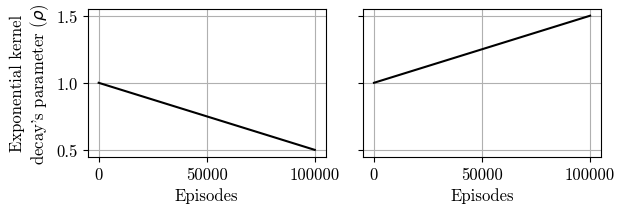

In [16]:
# Create an increasing x-axis representing wall time
wall_time = np.arange(1, n_episode + 1)

# Create a figure with two vertical subplots
fig, axs = plt.subplots(1, 2, figsize=(6.5,2.3), sharey=True, sharex=True)

# Linear decrease
axs[0].plot(wall_time, env_simulation_ld.kernel.decay_history, color="black")
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel("Exponential kernel\ndecay's parameter " +  r"($\rho$)", fontsize=12)
axs[0].grid(True)

# Linear increase
axs[1].plot(wall_time, env_simulation_li.kernel.decay_history, color="black")
axs[1].set_xlabel('Episodes')
axs[1].grid(True)
#axs[1].set_ylabel('\nb', color='white')
#axs[1].set_ylabel('Decay parameter (rho)')

# add title
#plt.suptitle("Exponential kernel\ndecay's parameter (rho)", fontsize=18)

# Show grid lines


# Adjust layout
plt.tight_layout()

# Save
plt.savefig(output_path_ld + "online_experiment_kernel.png", dpi=175)

# Show the plot
plt.show()


# Reward plot

/var/folders/f_/vxkztmj55t58xvh49q60z48w0000gn/T/ipykernel_7619/1590390242.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(1, 2, figsize=(6.5,3), sharey=True, sharex=True)
/var/folders/f_/vxkztmj55t58xvh49q60z48w0000gn/T/ipykernel_7619/1590390242.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


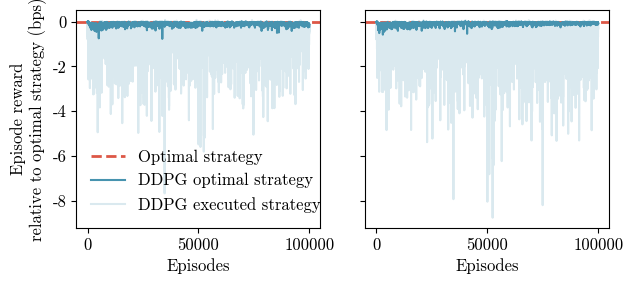

In [17]:
# Create a figure with two vertical subplots
fig, axs = plt.subplots(1, 2, figsize=(6.5,3), sharey=True, sharex=True)

# Linear decrease
axs[0].axhline(
        y=0, color = color_optimal,  label="Optimal strategy", linestyle="--",linewidth = 2
    )
axs[0].plot(episodes_selected, prop_reward_best_ld, color=color_ddpg, label='DDPG optimal strategy')
axs[0].plot(episodes_selected, prop_reward_executed_ld, color=color_ddpg, alpha = 0.2, label='DDPG executed strategy')
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Episode reward\nrelative to optimal strategy (bps)', fontsize=12)
axs[0].legend(fancybox=False, shadow=False, frameon = False)

# Linear increase
axs[1].axhline(
        y=0, color = color_optimal,  label="Optimal strategy", linestyle="--",linewidth = 2
    )
axs[1].plot(episodes_selected, prop_reward_best_li, color=color_ddpg, label='DDPG optimal strategy')
axs[1].plot(episodes_selected, prop_reward_executed_li, color=color_ddpg, alpha = 0.2, label='DDPG executed strategy')
axs[1].set_xlabel('Episodes')

# add text
# axs[0].text(x = 0, y = 0.5, s = "Best reward: " + str(round(prop_cum_reward_best_ld, 3)))
# axs[0].text(x = 0, y = 1, s = "Executed reward: " + str(round(prop_cum_reward_executed_ld, 3)))

# axs[1].text(x = 0, y = 0.5, s = "Best reward: " + str(round(prop_cum_reward_best_li, 3)))
# axs[1].text(x = 0, y = 1, s = "Executed reward: " + str(round(prop_cum_reward_executed_li, 3)))

fig.tight_layout()

# save
fig.savefig(output_path_ld + "online_experiment_reward.png",dpi=175)

# Show the plot
fig.show()